# Cellule 1 — Install (Colab)

In [1]:
# ==============================================================================
# Cellule 1 : Installation des dépendances
# Justification : Installation des outils de scraping (BS4), de NLP (spaCy, NLTK)
# et d'analyse de données (Scikit-learn, Pandas) nécessaires au pipeline.
# ==============================================================================

# Installation silencieuse des bibliothèques
!pip -q install beautifulsoup4 lxml spacy langdetect scikit-learn nltk wordcloud tqdm pandas matplotlib seaborn

# Téléchargement des modèles linguistiques spaCy pour le Text Mining (FR et EN)
# Note : L'utilisation de modèles légers (_sm) assure une exécution rapide en Colab.
!python -m spacy download fr_core_news_sm -q
!python -m spacy download en_core_web_sm -q

print("✅ Environnement configuré avec succès.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 52.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 93.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✅ Environnement configuré avec succès.


## Cellule 2 — Imports + NLTK



In [2]:
# ==============================================================================
# Cellule 2 : Imports et Configuration Globale
# Justification : Centralisation des outils pour assurer la maintenance et la
# reproductibilité des analyses (critère de réplicabilité du projet).
# ==============================================================================

# --- 1. SYSTÈME, TEMPS ET REPRODUCTIBILITÉ ---
import os
import re
import time
import random
import hashlib
import unicodedata
import warnings
from urllib.parse import urljoin, urlparse

# Fixer les seeds pour la réplicabilité des analyses (K-Means, etc.)
import numpy as np
np.random.seed(42)
random.seed(42)

# Ignorer les warnings inutiles pour un rapport propre
warnings.filterwarnings('ignore')

# --- 2. COLLECTE DE DONNÉES (SCRAPING) ---
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm

# --- 3. TRAITEMENT DU LANGAGE NATUREL (NLP) ---
import spacy
import nltk
from langdetect import detect, DetectorFactory

# Fixer la seed pour langdetect (détection de langue constante)
DetectorFactory.seed = 42

# Téléchargements NLTK
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords

# --- 4. MACHINE LEARNING ET ANALYSE ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# --- 5. VISUALISATION DES DONNÉES ---
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Configuration esthétique des graphiques
sns.set_theme(style="whitegrid")
%matplotlib inline

print("✅ Bibliothèques importées et paramètres de reproductibilité fixés.")

✅ Bibliothèques importées et paramètres de reproductibilité fixés.


# Cellule 4 — Liste des festivals

In [3]:
# ==============================================================================
# Cellule 4 : Définition du corpus (Festivals sélectionnés)
# Justification : Sélection d'un échantillon diversifié (Europe/Monde) pour
# assurer la représentativité de l'analyse du discours écologique.
# ==============================================================================

import pandas as pd
from urllib.parse import urlparse

festivals = [
    {"festival": "Tomorrowland", "url": "https://www.tomorrowland.com", "country": "BE", "lang": "en"},
    {"festival": "Rock Werchter", "url": "https://www.rockwerchter.be", "country": "BE", "lang": "en"},
    {"festival": "Pukkelpop", "url": "https://www.pukkelpop.be", "country": "BE", "lang": "nl"},
    {"festival": "Dour Festival", "url": "https://www.dourfestival.eu", "country": "BE", "lang": "fr"},
    {"festival": "Les Ardentes", "url": "https://www.lesardentes.be", "country": "BE", "lang": "fr"},
    {"festival": "Gent Jazz", "url": "https://www.gentjazz.com", "country": "BE", "lang": "nl"},
    {"festival": "Couleur Café", "url": "https://www.couleurcafe.be", "country": "BE", "lang": "fr"},
    {"festival": "Esperanzah!", "url": "https://www.esperanzah.be", "country": "BE", "lang": "fr"},
    {"festival": "Glastonbury Festival", "url": "https://www.glastonburyfestivals.co.uk", "country": "UK", "lang": "en"},
    {"festival": "Boom Festival", "url": "https://boomfestival.org", "country": "PT", "lang": "en"},
    {"festival": "Roskilde Festival", "url": "https://www.roskilde-festival.dk", "country": "DK", "lang": "en"},
    {"festival": "Sziget Festival", "url": "https://szigetfestival.com", "country": "HU", "lang": "en"},
    {"festival": "Primavera Sound", "url": "https://www.primaverasound.com", "country": "ES", "lang": "en"},
    {"festival": "Coachella", "url": "https://www.coachella.com", "country": "US", "lang": "en"},
    {"festival": "Burning Man", "url": "https://burningman.org", "country": "US", "lang": "en"},
    {"festival": "Montreux Jazz Festival", "url": "https://www.montreuxjazzfestival.com", "country": "CH", "lang": "fr"},
    {"festival": "Hellfest", "url": "https://www.hellfest.fr", "country": "FR", "lang": "fr"},
    {"festival": "Lollapalooza", "url": "https://www.lollapalooza.com", "country": "US", "lang": "en"},
    {"festival": "Rock am Ring", "url": "https://www.rock-am-ring.com", "country": "DE", "lang": "de"},
    {"festival": "Reading & Leeds", "url": "https://www.readingandleedsfestival.com", "country": "UK", "lang": "en"},
    {"festival": "Ultra Music Festival", "url": "https://ultramusicfestival.com", "country": "US", "lang": "en"},
    {"festival": "Fuji Rock Festival", "country": "JP", "url": "https://en.fujirockfestival.com", "lang": "en"},
    {"festival": "Exit Festival", "url": "https://www.exitfest.org", "country": "RS", "lang": "en"},
    {"festival": "Rock en Seine", "url": "https://www.rockenseine.com", "country": "FR", "lang": "fr"},
    {"festival": "Bonnaroo", "url": "https://www.bonnaroo.com", "country": "US", "lang": "en"},
    {"festival": "Electric Daisy Carnival", "url": "https://www.insomniac.com/events/edc-las-vegas", "country": "US", "lang": "en"},
    {"festival": "Lowlands", "url": "https://lowlands.nl", "country": "NL", "lang": "nl"},
    {"festival": "Download Festival", "url": "https://downloadfestival.co.uk", "country": "UK", "lang": "en"},
    {"festival": "Splendour in the Grass", "url": "https://www.splendourinthegrass.com", "country": "AU", "lang": "en"},
    {"festival": "Vieilles Charrues", "url": "https://www.vieillescharrues.asso.fr", "country": "FR", "lang": "fr"}
]

df_fest = pd.DataFrame(festivals)

# Extraction automatique du domaine racine pour faciliter le scraping ultérieur
df_fest['domain'] = df_fest['url'].apply(lambda x: urlparse(x).netloc.replace('www.', ''))

print(f"✅ Corpus prêt : {len(df_fest)} festivals répertoriés.")
display(df_fest.head())

✅ Corpus prêt : 30 festivals répertoriés.


,festival,url,country,lang,domain
0,Tomorrowland,https://www.tomorrowland.com,BE,en,tomorrowland.com
1,Rock Werchter,https://www.rockwerchter.be,BE,en,rockwerchter.be
2,Pukkelpop,https://www.pukkelpop.be,BE,nl,pukkelpop.be
3,Dour Festival,https://www.dourfestival.eu,BE,fr,dourfestival.eu
4,Les Ardentes,https://www.lesardentes.be,BE,fr,lesardentes.be


# Cellule 5 — Paramètres scraping (safe + filtrage éco)

In [4]:
# ==============================================================================
# Cellule 5 : Stratégie de collecte et filtrage thématique
# Justification : Mise en œuvre d'une collecte ciblée pour maximiser la pertinence
# du corpus tout en minimisant le bruit (Consigne 3.1).
# ==============================================================================

# 1. Configuration des limites et de la courtoisie (Politeness)
SCRAPING_CONFIG = {
    "timeout": 15,
    "sleep_delay": 1.5,          # Respect des serveurs (anti-ban)
    "max_pages_per_site": 35,    # Volume raisonnable vs bruit
    "max_depth": 3,              # Profondeur de navigation
    "user_agent": "WebMining-Student-Project/1.0 (Academic Research)",
}

# 2. Thésaurus multilingue pour le filtrage thématique
ECO_KEYWORDS = [
    # Français
    "durable", "durabilité", "environnement", "écologie", "responsable",
    "climat", "carbone", "déchet", "mobilité", "énergie", "charte", "engagement",
    # Anglais
    "sustainability", "environment", "green", "csr", "impact", "carbon",
    "waste", "recycl", "transport", "biodiversity", "circular", "planet",
    # Néerlandais / Allemand (essentiel pour les festivals belges/allemands)
    "duurzaam", "milieu", "klimaat", "afval", "umwelt", "nachhaltig"
]

# 3. Extensions à exclure (Filtres de bruit)
BAD_EXTENSIONS = (
    '.jpg', '.jpeg', '.png', '.gif', '.pdf', '.docx', '.zip',
    '.mp4', '.avi', '.mov', '.wav', '.mp3', '.css', '.js'
)

def is_internal_url(url, base_domain):
    """Vérifie si l'URL appartient au festival et n'est pas un fichier binaire."""
    try:
        parsed = urlparse(url)
        # On compare le domaine racine extrait en cellule 4
        is_internal = base_domain in parsed.netloc
        is_not_file = not parsed.path.lower().endswith(BAD_EXTENSIONS)
        return is_internal and is_not_file
    except:
        return False

def is_eco_relevant(url, anchor_text=""):
    """
    Détermine la pertinence écologique d'un lien.
    Analyse l'URL ET le texte du lien (plus robuste que l'URL seule).
    """
    target = (url + " " + anchor_text).lower()
    # Utilisation de regex pour éviter les correspondances partielles (ex: "decoration")
    return any(re.search(rf"\b{k}\b", target) or k in target for k in ECO_KEYWORDS)

print(f"✅ Stratégie de filtrage configurée ({len(ECO_KEYWORDS)} mots-clés).")

✅ Stratégie de filtrage configurée (30 mots-clés).


# Cellule 6 — Fonctions HTML → texte

In [5]:
# ==============================================================================
# Cellule 6 : Fonctions de parsing HTML et extraction de structure
# Justification : Extraction du contenu textuel (Text Mining) et de la structure
# des hyperliens (Link Analysis) pour répondre aux deux piliers du projet.
# ==============================================================================

def fetch_html(url):
    """Récupère le contenu HTML avec gestion d'erreurs détaillée."""
    try:
        # On utilise une session pour plus d'efficacité
        with requests.Session() as session:
            response = session.get(
                url,
                headers={'User-Agent': SCRAPING_CONFIG["user_agent"]},
                timeout=SCRAPING_CONFIG["timeout"],
                allow_redirects=True
            )
            response.raise_for_status() # Lève une exception si status != 200
            return response.text
    except Exception as e:
        # Pour le rapport : consigner les erreurs permet d'évaluer la qualité du corpus
        return None

def extract_page_data(html_content, current_url, base_domain):
    """Extrait le texte propre et les liens structurés d'une page."""
    if not html_content:
        return None, []

    soup = BeautifulSoup(html_content, "lxml")

    # --- 1. Extraction pour le TEXT MINING ---
    title = soup.title.get_text(strip=True) if soup.title else ""

    # Nettoyage sélectif du DOM (on enlève ce qui n'est pas du contenu éditorial)
    for tag in soup(["script", "style", "noscript", "form", "footer", "nav"]):
        tag.decompose()

    # Extraction du texte propre
    main_text = soup.get_text(separator=" ")
    main_text = re.sub(r"\s+", " ", main_text).strip()

    # --- 2. Extraction pour le LINK ANALYSIS ---
    links_data = []
    for a in soup.find_all("a", href=True):
        href = a["href"].strip()
        anchor_text = a.get_text(strip=True)

        # Résolution de l'URL absolue
        full_url = urljoin(current_url, href).split("#")[0].rstrip('/')

        # Validation : Interne, non-fichier, et pas mailto/tel
        if is_internal_url(full_url, base_domain) and not full_url.startswith(('mailto:', 'tel:', 'javascript:')):
            links_data.append({
                "source": current_url,
                "target": full_url,
                "anchor": anchor_text
            })

    return {
        "url": current_url,
        "title": title,
        "content": main_text
    }, links_data

print("✅ Fonctions d'extraction prêtes (Text + Link Analysis).")

✅ Fonctions d'extraction prêtes (Text + Link Analysis).


# Cellule 7 — Crawler limité (home + pages “éco”)

In [6]:
# ==============================================================================
# Cellule 7 : Crawler ciblée (Focus Thématique)
# Justification : Implémentation d'un crawler sélectif qui priorise les contenus
# liés à la durabilité pour construire un corpus à haute densité informationnelle.
# ==============================================================================

def crawl_festival(festival_name, start_url, base_domain):
    visited = set()
    # (url, depth, anchor_text)
    to_visit = [(start_url, 0, "homepage")]

    festival_pages = []
    festival_edges = []

    scanned_count = 0

    # On utilise une barre de progression discrète par festival
    with tqdm(total=SCRAPING_CONFIG["max_pages_per_site"], desc=f"🕷️ {festival_name}", leave=False) as pbar:

        while to_visit and len(festival_pages) < SCRAPING_CONFIG["max_pages_per_site"]:
            # On récupère l'URL avec la plus haute priorité
            current_url, depth, anchor = to_visit.pop(0)

            if current_url in visited:
                continue

            visited.add(current_url)
            scanned_count += 1

            # Respect du délai entre les requêtes (Politeness)
            time.sleep(SCRAPING_CONFIG["sleep_delay"])

            html = fetch_html(current_url)
            if not html:
                continue

            # Extraction des données et des liens
            page_data, links = extract_page_data(html, current_url, base_domain)

            if not page_data:
                continue

            # --- CRITÈRE DE SAUVEGARDE (Consigne 3.1 : Pertinence) ---
            # On garde la home et toute page identifiée comme éco-responsable
            if depth == 0 or is_eco_relevant(current_url, anchor) or is_eco_relevant(current_url, page_data['title']):
                page_data["festival"] = festival_name
                page_data["depth"] = depth
                festival_pages.append(page_data)
                pbar.update(1)

            # --- STRATÉGIE D'EXPLORATION (LINK ANALYSIS) ---
            if depth < SCRAPING_CONFIG["max_depth"]:
                for link in links:
                    target_url = link["target"]
                    target_anchor = link["anchor"]

                    # On stocke TOUS les liens internes pour le futur Link Analysis
                    festival_edges.append({
                        "festival": festival_name,
                        "source": current_url,
                        "target": target_url,
                        "anchor": target_anchor
                    })

                    if target_url not in visited:
                        # PRIORISATION : On met les liens "éco" en début de liste (Queue)
                        if is_eco_relevant(target_url, target_anchor):
                            to_visit.insert(0, (target_url, depth + 1, target_anchor))
                        else:
                            # Les autres liens sont mis à la fin (exploration secondaire)
                            to_visit.append((target_url, depth + 1, target_anchor))

            # Sécurité pour ne pas boucler indéfiniment sur un site complexe
            if scanned_count > 100:
                break

    return festival_pages, festival_edges

print("✅ Moteur de crawling stratégique prêt.")

✅ Moteur de crawling stratégique prêt.


# Cellule 8 — Lancer la collecte (scraping)

In [7]:
# ==============================================================================
# Cellule 8 : Lancement de la collecte globale et consolidation du corpus
# Justification : Agrégation des données multidimensionnelles (texte + liens)
# et enrichissement par métadonnées pour permettre l'analyse comparative.
# ==============================================================================

all_pages = []
all_links = []

print(f"🚀 Lancement de la collecte sur {len(df_fest)} festivals...")

# Utilisation de tqdm pour la progression globale
for _, row in tqdm(df_fest.iterrows(), total=len(df_fest), desc="Global Progress"):
    fest_name = row["festival"]
    start_url = row["url"]
    domain = row["domain"]
    country = row["country"]
    main_lang = row["lang"]

    try:
        # Crawl ciblé (Utilise la stratégie définie en Cellule 7)
        pages, links = crawl_festival(fest_name, start_url, domain)

        if pages:
            # On enrichit chaque page avec les métadonnées du festival
            for p in pages:
                p["country"] = country
                p["main_lang"] = main_lang

            all_pages.extend(pages)
            all_links.extend(links)

            # Sauvegarde de sécurité incrémentale
            pd.DataFrame(all_pages).to_csv("backup_pages.csv", index=False)

    except Exception as e:
        print(f"\n⚠️ Échec sur {fest_name} : {e}")
        continue

# --- TRAITEMENT ET NETTOYAGE FINAL ---

# 1. Création des DataFrames
df_corpus = pd.DataFrame(all_pages)
df_network = pd.DataFrame(all_links)

# 2. Déduplication rigoureuse (basée sur l'URL)
df_corpus.drop_duplicates(subset=["url"], inplace=True)
df_network.drop_duplicates(subset=["source", "target"], inplace=True)

# 3. FILTRE DE QUALITÉ (Consigne 3.2 : Bruit et lacunes)
# On retire les pages trop pauvres en contenu (souvent des pages de redirection ou menus)
min_char_limit = 300
initial_count = len(df_corpus)
df_corpus = df_corpus[df_corpus['content'].str.len() > min_char_limit]

# 4. Sauvegarde finale au format CSV (Consigne 3.1 : Format utilisable)
df_corpus.to_csv("corpus_festivals_text_mining.csv", index=False, encoding='utf-8-sig')
df_network.to_csv("corpus_festivals_links.csv", index=False, encoding='utf-8-sig')

print(f"\n✅ Collecte terminée avec succès !")
print(f"📊 Volume final : {len(df_corpus)} pages pertinentes (Bruit filtré : {initial_count - len(df_corpus)} pages).")
print(f"🕸️ Graphe : {len(df_network)} relations extraites.")

🚀 Lancement de la collecte sur 30 festivals...


Global Progress: 100%|██████████| 30/30 [1:01:08<00:00, 122.29s/it]



✅ Collecte terminée avec succès !
📊 Volume final : 89 pages pertinentes (Bruit filtré : 9 pages).
🕸️ Graphe : 34628 relations extraites.


# Cellule 9 : Injection manuelle et Scraping Avancé (Next.js)

In [8]:
# ==============================================================================
# Cellule 9 : Gestion des cas particuliers et injection manuelle
# Justification : Traitement des sites en Single Page Application (Next.js) et
# ajout de pages stratégiques ciblées pour enrichir le corpus (Consigne 3.1).
# ==============================================================================

import json

# Dictionnaire des pages clés (souvent difficiles à trouver par un crawl automatique)
MANUAL_ECO_URLS = {
    "Boom Festival": ["https://boomfestival.org/environment/boom-eco-paradigm"],
    "Primavera Sound": ["https://www.primaverasound.com/en/porto/porto-best-practices-manual-2024"],
    "Reading & Leeds": ["https://www.readingfestival.com/info-category/staying-green"],
    "Rock am Ring": ["https://www.rock-am-ring.com/en/sustainability"],
    "Tomorrowland" : ["https://lovetomorrow.com/projects/"]
}

def extract_text_from_next_data(html_content) -> str:
    """Extrait les données textuelles des scripts de données Next.js."""
    if not html_content: return ""
    soup = BeautifulSoup(html_content, "lxml")
    script_tag = soup.find("script", id="__NEXT_DATA__")

    if not script_tag or not script_tag.string:
        return ""

    try:
        data = json.loads(script_tag.string)
        strings = []
        def walk(x):
            if isinstance(x, dict):
                for v in x.values(): walk(v)
            elif isinstance(x, list):
                for v in x: walk(v)
            elif isinstance(x, str):
                if len(x.strip()) >= 30: # Filtre le bruit (menus, icônes)
                    strings.append(x.strip())
        walk(data)
        joined = " ".join(strings)
        # Nettoyage final du texte (retrait des balises HTML résiduelles dans le JSON)
        return BeautifulSoup(joined, "html.parser").get_text(" ", strip=True)
    except Exception:
        return ""

def inject_manual_pages(df_main, manual_dict):
    """Injecte ou met à jour des pages spécifiques avec un traitement Next.js si besoin."""
    new_rows = []

    for fest, urls in manual_dict.items():
        # Récupération des métadonnées depuis df_fest pour la cohérence
        meta = df_fest[df_fest["festival"] == fest].iloc[0]

        for url in urls:
            print(f"🎯 Injection manuelle : {fest} -> {url}")
            html = fetch_html(url)
            if not html: continue

            # Essai Next.js puis fallback classique
            text = extract_text_from_next_data(html)
            if not text or len(text.split()) < 50:
                # Utilise notre fonction de nettoyage standard si Next.js échoue
                page_data, _ = extract_page_data(html, url, meta['domain'])
                text = page_data['content'] if page_data else ""

            if text and len(text.split()) >= 50:
                row = {
                    "festival": fest,
                    "url": url,
                    "title": BeautifulSoup(html, "lxml").title.string if BeautifulSoup(html, "lxml").title else "Manual Entry",
                    "content": text,
                    "depth": 1,
                    "country": meta["country"],
                    "main_lang": meta["lang"]
                }
                new_rows.append(row)

    # Mise à jour du DataFrame original
    df_manual = pd.DataFrame(new_rows)
    # On concatène et on retire les doublons en gardant la version manuelle (la plus riche)
    df_combined = pd.concat([df_manual, df_main], ignore_index=True)
    df_combined.drop_duplicates(subset=["url"], keep="first", inplace=True)

    return df_combined

# Application
df_corpus = inject_manual_pages(df_corpus, MANUAL_ECO_URLS)
print(f"✅ Corpus finalisé : {len(df_corpus)} pages.")

🎯 Injection manuelle : Boom Festival -> https://boomfestival.org/environment/boom-eco-paradigm
🎯 Injection manuelle : Primavera Sound -> https://www.primaverasound.com/en/porto/porto-best-practices-manual-2024
🎯 Injection manuelle : Reading & Leeds -> https://www.readingfestival.com/info-category/staying-green
🎯 Injection manuelle : Rock am Ring -> https://www.rock-am-ring.com/en/sustainability
🎯 Injection manuelle : Tomorrowland -> https://lovetomorrow.com/projects/
✅ Corpus finalisé : 93 pages.


#Cellule 10 : Diagnostic Qualitatif du Corpus (Optimisée)

In [9]:
# ==============================================================================
# Cellule 10 : Diagnostic et filtrage qualitatif du corpus (CORRIGÉE)
# Justification : Évaluation de la qualité du corpus et normalisation
# linguistique pour préparer le Text Mining (Consigne 3.2).
# ==============================================================================

from langdetect import detect

def safe_detect(text):
    """Fonction sécurisée pour détecter la langue d'un texte."""
    try:
        if not text or len(str(text).strip()) < 10:
            return "unknown"
        return detect(text)
    except:
        return "unknown"

# 1. Calcul des statistiques de volume initial
initial_count = len(df_corpus)
df_corpus.drop_duplicates(subset=["url"], inplace=True)
unique_count = len(df_corpus)

# 2. Analyse de la longueur des documents (Consigne 3.2 : Bruit)
# Utilisation de la colonne 'content' définie lors du scraping
df_corpus["n_words"] = df_corpus["content"].fillna("").apply(lambda x: len(str(x).split()))

# Filtrage des pages trop courtes (Bruit)
min_words_threshold = 50
df_corpus = df_corpus[df_corpus["n_words"] >= min_words_threshold].copy()

# 3. Détection et filtrage linguistique
print("🔍 Détection des langues en cours...")
df_corpus['lang_detected'] = df_corpus['content'].apply(lambda x: safe_detect(str(x)[:1000]))

# On se concentre sur les langues demandées (EN, FR, NL)
supported_langs = ["en", "fr", "nl"]
df_pages = df_corpus[df_corpus["lang_detected"].isin(supported_langs)].copy()

# 4. Affichage du bilan pour le rapport (Consigne 4.1)
print("\n" + "="*40)
print("📊 BILAN DU CORPUS POUR LE RAPPORT")
print("="*40)
print(f"Documents bruts collectés : {initial_count}")
print(f"Après dédoublonnage      : {unique_count}")
print(f"Après filtre (min {min_words_threshold} mots) : {len(df_corpus)}")
print(f"Après filtre linguistique ({', '.join(supported_langs)}) : {len(df_pages)}")
print("-"*40)
print("🌍 Répartition linguistique finale :")
print(df_pages['lang_detected'].value_counts())
print("="*40)

# Statistiques descriptives de longueur (Consigne 3.2)
display(df_pages["n_words"].describe().to_frame().T)

🔍 Détection des langues en cours...

📊 BILAN DU CORPUS POUR LE RAPPORT
Documents bruts collectés : 93
Après dédoublonnage      : 93
Après filtre (min 50 mots) : 93
Après filtre linguistique (en, fr, nl) : 85
----------------------------------------
🌍 Répartition linguistique finale :
lang_detected
en    63
fr    15
nl     7
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
n_words,85.0,854.823529,1355.175838,51.0,289.0,616.0,839.0,10229.0


#Cellule 11 : Dictionnaires de Text Mining & Injection Automatisée

In [10]:
# ==============================================================================
# Cellule 11 : Lexiques d'analyse sémantique et enrichissement automatique
# Justification : Création de thésaurus pour distinguer le discours factuel (concret)
# du discours aspirationnel (vague) conformément aux objectifs du sujet 9.
# ==============================================================================

def normalize_text_for_matching(text: str) -> str:
    """Normalise le texte pour un matching robuste."""
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r"[-_/]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

def count_keywords_exact(text, patterns) -> int:
    """Compte les occurrences exactes basées sur des patterns regex."""
    if not isinstance(text, str) or not text.strip(): return 0
    t = normalize_text_for_matching(text)
    return sum(len(p.findall(t)) for p in patterns)

# --- 1) ECO_KEYWORDS : détecter les pages "durabilité / responsabilité"
eco_keywords = [
    # --- CORE (EN/FR/NL) ---
    "sustainability", "sustainable", "sustainably",
    "durabilité", "durable", "développement durable", "developpement durable",
    "duurzaam", "duurzaamheid",
    "environment", "environmental", "environnement", "environnemental", "milieu",
    "ecology", "ecological", "écologie", "ecologique", "ecologie",
    "green", "greener", "vert", "groen",
    "climate", "climat", "klimaat",
    "carbon", "carbone", "co2", "ghg", "emissions", "émissions", "uitstoot",
    "footprint", "empreinte", "voetafdruk",
    "net zero", "net-zero", "neutralité carbone", "neutralite carbone", "carbon neutral", "climate neutral",

    # --- STRATÉGIE / POLITIQUE / PROGRAMMES ---
    "responsibility", "responsable", "verantwoord", "verantwoordelijkheid",
    "csr", "rse", "esg", "sdg", "un sdg", "agenda 2030",
    "policy", "policies", "politique", "charter", "charte", "pledge", "commitment", "engagement",
    "strategy", "strategies", "stratégie", "strategie", "roadmap", "plan d'action", "action plan",
    "report", "reporting", "rapport", "transparency", "transparence",
    "governance", "gouvernance",

    # --- NATURE / EAU / AIR ---
    "nature", "biodiversity", "biodiversité", "biodiversiteit",
    "ecosystem", "écosystème", "ecosysteem",
    "wildlife", "fauna", "flora",
    "water", "eau", "drinkwater", "groundwater",
    "air quality", "qualité de l'air", "luchtkwaliteit",

    # --- ÉNERGIE ---
    "energy", "énergie", "energie",
    "renewable", "renewables", "renouvelable", "renouvelables", "hernieuwbaar", "hernieuwbare",
    "solar", "solaire", "zonne", "zonnepanelen", "wind", "éolien", "eolien", "windenergie",
    "efficiency", "efficacité", "efficacite", "efficiëntie", "efficiente",
    "led", "lighting", "lumière", "verlichting",

    # --- DÉCHETS / CIRCULAIRE ---
    "waste", "wastes", "déchet", "déchets", "dechet", "dechets", "afval",
    "recycle", "recycled", "recycling", "recyclage", "recycleren",
    "circular", "circularity", "circulaire", "circulariteit",
    "reuse", "re-use", "réutilisation", "hergebruik",
    "plastic", "single use", "single-use", "plastique", "wegwerp",
    "zero waste", "zéro déchet", "zero-waste",
    "compost", "composting", "compostage",
    "litter", "clean-up", "cleanup", "zwerfvuil",

    # --- MOBILITÉ ---
    "transport", "mobility", "mobilité", "mobiliteit",
    "public transport", "transports en commun",
    "train", "trein", "rail", "sncb", "ns", "renfe", "db", "sbb",
    "bus", "shuttle", "navette", "pendelbus",
    "carpool", "car pooling", "covoiturage", "rideshare",
    "bike", "bicycle", "vélo", "velo", "fiets", "cycling",
    "parking vélo", "bike parking", "fietsenstalling",

    # --- ALIMENTATION / ACHATS ---
    "local", "locally", "lokaal",
    "circuit court", "short supply chain", "korte keten",
    "organic", "bio", "biologique", "biologisch",
    "plant based", "plant-based", "végétarien", "vegetarian", "vegan",
    "fair trade", "fairtrade", "commerce équitable", "eerlijke handel",
]

# --- 2) KEYWORDS_CONCRETS : mesures / preuves / dispositifs techniques
# (FR/EN/NL + formulations typiques des festivals internationaux)
keywords_concrets = [
    # A) Mesures quantifiées / reporting
    "kg", "kgs", "kilogram", "kilograms", "ton", "tons", "tonne", "tonnes",
    "litre", "litres", "l", "m3", "kwh", "mwh", "gwh",
    "scope 1", "scope 2", "scope 3", "ghg protocol",
    "baseline", "target", "targets", "objective", "objectifs",
    "measured", "measuring", "monitoring", "measurable", "mesurable",
    "audit", "audited", "certified", "certification", "certifié", "certifie",

    # B) Énergie / infrastructure
    "solar", "solaire", "zonnepanelen", "photovoltaic", "pv",
    "wind", "éolien", "eolien", "windenergie",
    "renewable electricity", "green electricity", "énergie verte", "groene stroom",
    "led", "led lighting", "smart lighting",
    "generator", "generators", "générateur", "generateur", "diesel generator",
    "battery", "batteries", "storage", "energy storage",
    "heat pump", "pompe à chaleur", "warmtepomp",

    # C) Déchets / tri / réemploi (très concret)
    "sorting", "sorteren", "tri", "tri sélectif", "selective sorting",
    "pmc", "pmd", "papier", "paper", "cardboard", "carton",
    "glass", "verre", "glas", "metal", "aluminium", "can", "cans",
    "compost", "composting", "compostage",
    "reusable cup", "reusable cups", "gobelet réutilisable", "gobelets réutilisables",
    "herbruikbare beker", "beker", "gobelet", "cup deposit", "deposit system", "consigne",
    "refill", "refill station", "water refill", "refill points", "refillable",
    "single-use ban", "ban single use", "interdiction", "no single use",
    "waste management", "gestion des déchets", "afvalbeheer",
    "waste sorting stations", "tri stations", "recycling points",

    # D) Eau
    "drinking water", "eau potable", "drinkwater",
    "water fountain", "fontaine", "water station", "hydration station",
    "tap water", "water points",

    # E) Mobilité (mesures concrètes)
    "shuttle", "navette", "pendelbus",
    "train", "trein", "rail", "sncb", "ns", "db", "renfe",
    "bike", "bicycle", "vélo", "fiets", "bike parking", "fietsenstalling",
    "carpool", "covoiturage", "rideshare",
    "park and ride", "p+r", "park&ride",
    "ticket discount", "discounted", "free shuttle",

    # F) Alimentation / achats concrets
    "local suppliers", "fournisseurs locaux", "lokale leveranciers",
    "plant-based options", "vegetarian options", "vegan options",
    "seasonal", "saisonnier", "seizoensgebonden",
    "reusable tableware", "vaisselle réutilisable", "herbruikbaar servies",
    "no plastic straws", "paper straws", "no plastic bottles",

    # G) Labels / normes / standards (preuves)
    "iso 20121", "iso20121",
    "b corp", "b-corp", "b corporation",
    "green key", "clef verte", "clé verte",
    "emAS", "emas",
    "fsc", "pefc",
    "gots", "oekotex", "oeko-tex",
    "fairtrade", "fair trade",

    # H) Organisation / dispositifs internes (opérationnel)
    "green team", "sustainability team", "équipe durable",
    "training", "formation", "staff training",
    "suppliers code", "supplier code of conduct", "code fournisseur",
    "green rider", "artist rider", "rider écologique", "eco rider",
    "waste contractor", "recycling partner",
]

# --- 3) KEYWORDS_VAGUES : aspirationnel / valeurs / langage marketing green
# (on vise des mots "flous" sans éléments actionnables)
keywords_vagues = [
    # Valeurs / émotions
    "love", "amour", "together", "ensemble", "samen",
    "spirit", "esprit", "vibe", "good vibes",
    "dream", "rêve", "reve", "droom",
    "magic", "magie", "unique", "unforgettable", "inoubliable",
    "experience", "expérience", "ervaring",
    "community", "communauté", "gemeenschap",
    "harmony", "harmonie", "peace", "paix", "respect", "respectful",

    # Formulations typiques "greenwashing soft"
    "we care", "we believe", "we aim", "we strive", "we want to",
    "commit to", "committed to", "engaged", "engagé", "engageons",
    "raise awareness", "sensibiliser", "awareness", "conscience", "bewustzijn",
    "future", "futur", "avenir", "toekomst",
    "make a difference", "changer les choses", "better world", "monde meilleur",
    "protect the planet", "save the planet", "for the planet", "pour la planète",
    "eco-friendly", "environmentally friendly", "planet-friendly",
    "green mindset", "green journey", "sustainability journey",
    "inspired", "inspiration", "inspirant", "inspiring",
    "positive impact", "impact positif", "impactful",
]

def build_kw_pattern(kw: str) -> re.Pattern:
    """Construit un pattern regex robuste avec word boundaries."""
    kw_norm = normalize_text_for_matching(kw)
    parts = [re.escape(p) for p in kw_norm.split(" ")]
    core = r"\s+".join(parts)
    pattern = r"(?<![\w])" + core + r"(?![\w])"
    return re.compile(pattern, flags=re.IGNORECASE)

CONCRET_PATTERNS = [build_kw_pattern(k) for k in keywords_concrets]
VAGUE_PATTERNS   = [build_kw_pattern(k) for k in keywords_vagues]

ECO_KNOWN_PATHS = [
    "sustainability", "sustainable", "environment", "responsibility",
    "csr", "esg", "impact", "climate", "green",
    "durabilite", "durabilité", "environnement",
    "responsabilite", "responsabilité", "rse",
    "duurzaamheid", "milieu", "klimaat",
    "green-camping", "eco", "ecology", "environmental"
]

def inject_known_eco_pages(df_main, df_fest_ref):
    """Tente de forcer l'ajout de pages durabilité classiques si non trouvées."""
    new_rows = []
    for _, row_fest in df_fest_ref.iterrows():
        fest = row_fest["festival"]
        base = row_fest["url"].rstrip("/")
        for p in ECO_KNOWN_PATHS:
            url = f"{base}/{p}"
            if url in df_main["url"].values: continue
            html = fetch_html(url)
            if not html: continue
            page_data, _ = extract_page_data(html, url, row_fest['domain'])
            if page_data and len(page_data['content'].split()) >= 50:
                page_data.update({
                    "festival": fest, "depth": 1,
                    "country": row_fest["country"], "main_lang": row_fest["lang"]
                })
                new_rows.append(page_data)
    if new_rows:
        return pd.concat([df_main, pd.DataFrame(new_rows)], ignore_index=True).drop_duplicates(subset=["url"])
    return df_main

# Application
df_pages = inject_known_eco_pages(df_pages, df_fest)
df_pages["score_concret"] = df_pages["content"].apply(lambda x: count_keywords_exact(x, CONCRET_PATTERNS))
df_pages["score_vague"] = df_pages["content"].apply(lambda x: count_keywords_exact(x, VAGUE_PATTERNS))

print(f"✅ Analyse sémantique terminée. Score concret moyen : {df_pages['score_concret'].mean():.2f}")

✅ Analyse sémantique terminée. Score concret moyen : 14.12


#Cellule 12 : Scoring Sémantique et Consolidation par Festival

In [11]:
# ==============================================================================
# Cellule 12 : Scoring sémantique normalisé et bilan par festival
# Justification : Calcul de la densité lexicale (concret vs vague) pour
# permettre une comparaison équitable entre festivals (Consigne 3.2).
# ==============================================================================

# 1. Calcul des scores sur le texte brut (en utilisant la colonne 'content')
df_pages["score_concret"] = df_pages["content"].apply(lambda x: count_keywords_exact(x, CONCRET_PATTERNS))
df_pages["score_vague"]   = df_pages["content"].apply(lambda x: count_keywords_exact(x, VAGUE_PATTERNS))

# 2. Normalisation de la densité pour 500 mots (évite le biais de longueur)
# On utilise n_words calculé en cellule 10
df_pages["score_concret_norm"] = (df_pages["score_concret"] / df_pages["n_words"]) * 500
df_pages["score_vague_norm"]   = (df_pages["score_vague"]   / df_pages["n_words"]) * 500

# Sécurité : Remplacement des NaN par 0 (Consigne 4.3 : Robustesse du code)
df_pages[["score_concret_norm", "score_vague_norm"]] = df_pages[["score_concret_norm", "score_vague_norm"]].fillna(0)

# 3. Agrégation : On identifie la page la plus "performante" par festival
# max_stats capture les meilleures performances lexicales
max_stats = df_pages.groupby("festival")[["score_concret_norm", "score_vague_norm", "n_words"]].max().reset_index()

# 4. Identification de la meilleure URL (la plus concrète) pour le rapport
# On ne garde que les lignes avec du texte pour éviter les erreurs d'index
df_sub_valid = df_pages[df_pages["score_concret"].notna()].copy()
idx_best = df_sub_valid.groupby("festival")["score_concret"].idxmax()
best_pages = df_pages.loc[idx_best, ["festival", "url"]].rename(columns={"url": "best_eco_url"})

# 5. Consolidation finale (Tableau de bord Master)
df_festival_report = (
    df_fest[["festival", "country", "url"]]
    .rename(columns={"url": "base_url"})
    .merge(max_stats, on="festival", how="left")
    .merge(best_pages, on="festival", how="left")
    .fillna(0)
)

# Ajout d'un indicateur de succès de collecte
df_festival_report["scanned"] = df_festival_report["n_words"] > 0

# Tri par score concret décroissant pour l'analyse
df_festival_report = df_festival_report.sort_values("score_concret_norm", ascending=False)

print("✅ Scoring et consolidation terminés.")
display(df_festival_report[["festival", "country", "score_concret_norm", "score_vague_norm", "scanned"]].head(10))

✅ Scoring et consolidation terminés.


,festival,country,score_concret_norm,score_vague_norm,scanned
0,Tomorrowland,BE,28.985507,24.709302,True
3,Dour Festival,BE,22.191401,8.274232,True
7,Esperanzah!,BE,20.802377,6.711409,True
15,Montreux Jazz Festival,CH,19.607843,9.803922,True
14,Burning Man,US,18.292683,8.389262,True
16,Hellfest,FR,16.233766,6.369427,True
1,Rock Werchter,BE,13.033175,5.925251,True
19,Reading & Leeds,UK,6.912442,1.152074,True
29,Vieilles Charrues,FR,6.256517,0.521376,True
18,Rock am Ring,DE,5.952381,11.054422,True


#Cellule 13 : Construction du Graphe des Thématiques et Analyse de Liens

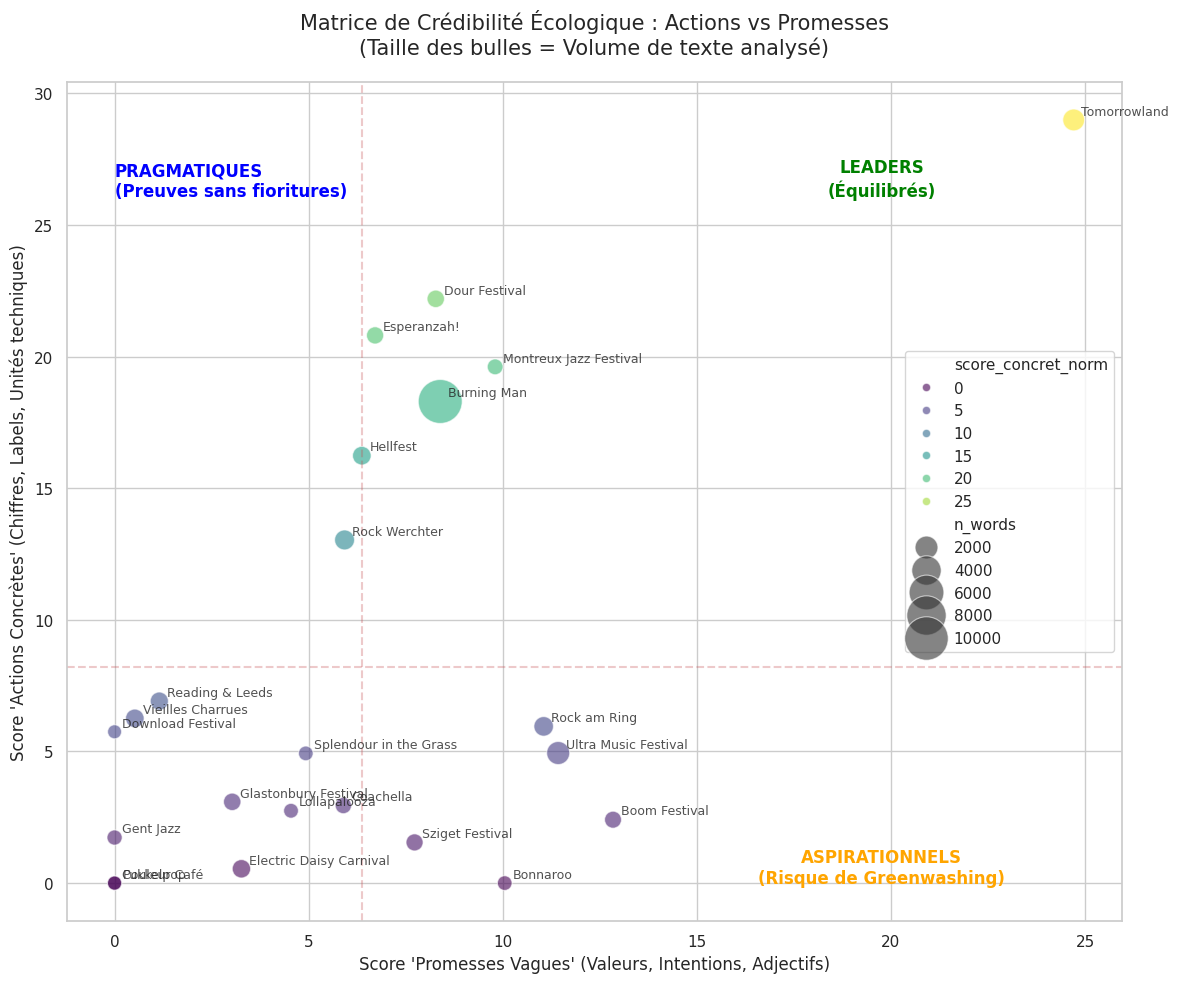

In [12]:
# ==============================================================================
# Cellule 13 : Graphique de positionnement stratégique (Crédibilité)
# Justification : Visualisation croisée des scores pour identifier les profils
# de communication : "Engagement concret" vs "Communication marketing" (Sujet 9).
# ==============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# On prépare les données (on utilise df_festival_report créé en Cellule 11c)
# On ne garde que les festivals qui ont été scrapés avec succès
df_viz = df_festival_report[df_festival_report["scanned"] == True].copy()

plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Création du nuage de points
scatter = sns.scatterplot(
    data=df_viz,
    x="score_vague_norm",
    y="score_concret_norm",
    size="n_words",
    sizes=(100, 1000),
    alpha=0.6,
    palette="viridis",
    hue="score_concret_norm"
)

# Ajout des labels pour chaque festival
for i in range(df_viz.shape[0]):
    plt.text(
        df_viz.score_vague_norm.iloc[i]+0.2,
        df_viz.score_concret_norm.iloc[i]+0.2,
        df_viz.festival.iloc[i],
        fontsize=9,
        alpha=0.8
    )

# Calcul des moyennes pour diviser le graphique en quadrants
mean_vague = df_viz["score_vague_norm"].mean()
mean_concret = df_viz["score_concret_norm"].mean()

plt.axvline(mean_vague, color='r', linestyle='--', alpha=0.3)
plt.axhline(mean_concret, color='r', linestyle='--', alpha=0.3)

# Annotation des quadrants pour le rapport (Analyse qualitative)
plt.text(df_viz["score_vague_norm"].max()*0.8, df_viz["score_concret_norm"].max()*0.9,
         "LEADERS\n(Équilibrés)", color='green', fontweight='bold', ha='center')
plt.text(df_viz["score_vague_norm"].min(), df_viz["score_concret_norm"].max()*0.9,
         "PRAGMATIQUES\n(Preuves sans fioritures)", color='blue', fontweight='bold')
plt.text(df_viz["score_vague_norm"].max()*0.8, df_viz["score_concret_norm"].min(),
         "ASPIRATIONNELS\n(Risque de Greenwashing)", color='orange', fontweight='bold', ha='center')

plt.title("Matrice de Crédibilité Écologique : Actions vs Promesses\n(Taille des bulles = Volume de texte analysé)", fontsize=15, pad=20)
plt.xlabel("Score 'Promesses Vagues' (Valeurs, Intentions, Adjectifs)", fontsize=12)
plt.ylabel("Score 'Actions Concrètes' (Chiffres, Labels, Unités techniques)", fontsize=12)

plt.tight_layout()
plt.savefig("matrice_credibilite.png", dpi=300)
plt.show()

# Cellule 14 : Cristallisation du Corpus Final (Optimisée)

In [13]:
# ==============================================================================
# Cellule 14 : Cristallisation et purification finale du corpus
# Justification : Élimination des pages administratives/commerciales (bruit)
# et fixation du volume de données pour assurer la réplicabilité (Consigne 3.1 & 4.3).
# ==============================================================================

# 1. Filtrage par longueur de texte (Robustesse statistique)
MIN_WORDS = 200
df_corpus = df_pages[df_pages["n_words"] >= MIN_WORDS].copy()

# 2. Filtrage sémantique par exclusion (Retrait du bruit hors-sujet)
EXCLUDE_PATTERNS = [
    "ticket", "shop", "store", "merch", "login", "lineup",
    "cookie", "privacy", "terms", "press", "media",
    "partner", "sponsor", "legal", "contact"
]

def is_relevant_page(row):
    # On vérifie l'URL et le Titre (Consigne 3.1 : filtres mots-clés)
    target = f"{row['url']} {row['title']}".lower()
    return not any(pat in target for pat in EXCLUDE_PATTERNS)

count_before = len(df_corpus)
df_corpus = df_corpus[df_corpus.apply(is_relevant_page, axis=1)].copy()

# 3. Dédoublonnage par normalisation d'URL
from urllib.parse import urlsplit, urlunsplit
def normalize_url(url):
    parts = urlsplit(url)
    # On retire les queries (?...) et les fragments (#...)
    return urlunsplit((parts.scheme, parts.netloc, parts.path, "", ""))

df_corpus["url_norm"] = df_corpus["url"].apply(normalize_url)
df_corpus = df_corpus.drop_duplicates(subset=["url_norm"]).copy()

# 4. Bilan et Sauvegarde (Consigne 4.1 : Rapport)
print(f"📊 BILAN DE PURIFICATION :")
print(f"   - Documents initiaux : {count_before}")
print(f"   - Hors-sujet écartés : {count_before - len(df_corpus)}")
print(f"   - Volume final gelé  : {len(df_corpus)} documents")

# Exportation au format structuré CSV (Consigne 3.1)
df_corpus.to_csv("corpus_final_webmining.csv", index=False, encoding="utf-8-sig")

# On remplace l'ancien dataframe pour la suite du pipeline
df_pages = df_corpus.copy()

📊 BILAN DE PURIFICATION :
   - Documents initiaux : 70
   - Hors-sujet écartés : 15
   - Volume final gelé  : 55 documents


# Cellule 15 — Nettoyage et Vectorisation TF-IDF (Version Consolidée)

In [14]:
# ==============================================================================
# Cellule 15 : Nettoyage sémantique Expert et Vectorisation TF-IDF (CORRIGÉ v2)
# Objectif : purifier le corpus (boilerplate web, temps/ticketing, branding résiduel,
# pages "infos générales") pour obtenir des clusters plus concrets.
# ==============================================================================

import re
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

# 1) Stopwords multilingues (FR/EN/NL)
nltk.download("stopwords", quiet=True)
STOP_TOTAL = (
    set(stopwords.words("french"))
    | set(stopwords.words("english"))
    | set(stopwords.words("dutch"))
)

# 2) Stopwords spécifiques (diagnostic + boilerplate + temps/ticketing + résidus)

FINAL_CLEAN_STOP = {
    # Résidus Web / UX
    "cookies", "cookie", "plus", "mode", "accessibility", "site", "website",

    # Bruit temporel (complété)
    "samedi", "vendredi", "dimanche", "jours", "day", "days",
    "juin", "june", "juillet", "july", "août", "aout", "august",

    # Marques / noms trop spécifiques (selon ton diagnostic)
    "rock", "festival", "festivals", "colour", "jazz", "gent", "glastonbury",
}

WEB_BOILER = {
    "cookie", "cookies", "consent", "privacy", "policy", "terms", "conditions", "legal", "gdpr",
    "newsletter", "subscribe", "subscription", "login", "account", "register", "signin", "signup",
    "menu", "nav", "navigation", "search", "home", "page", "pages", "site", "website",
    "accessibility", "accessible", "sitemap", "press", "media", "copyright",
    "contact", "contacts", "faq", "help", "support", "customer",
    "language", "français", "english", "nederlands", "deutsch",
    "share", "follow", "facebook", "instagram", "tiktok", "youtube", "linkedin", "twitter", "x",
    "download", "app", "apps", "android", "iphone", "ios",
    "map", "maps", "direction", "directions",
}

TIME_TICKETING = {
    "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday",
    "lundi", "mardi", "mercredi", "jeudi", "vendredi", "samedi", "dimanche",

    # mois / abréviations (complété)
    "jan", "january", "feb", "february", "mar", "march", "apr", "april", "may",
    "jun", "june", "jul", "july", "aug", "august", "sep", "sept", "september",
    "oct", "october", "nov", "november", "dec", "december",
    "septembre", "octobre", "novembre", "décembre", "decembre",

    # agenda / billetterie
    "horaire", "horaires", "schedule", "timetable", "lineup", "setlist",
    "ticket", "tickets", "billet", "billets", "pass", "passes", "vip",
    "checkout", "cart", "shop", "store", "merch",
}

# Résidus branding / naming (pour ton Cluster "tomorrow / winter / edition")
BRAND_RESIDUALS = {
    "tomorrow", "winter", "summer", "spring", "edition", "editions"
}

# Pages "infos générales" (pour éviter que ça écrase le cluster RSO)
INFO_PRACTICAL = {
    "info", "infos", "information", "informations",
    "general", "général", "generales", "générales", "practical", "pratiques",
    "useful", "guide"
}

# (Optionnel mais recommandé) stop automatique des mots du nom des festivals
# => évite les clusters "par marque"
fest_names = set(
    df_pages["festival"]
    .dropna()
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z\s]", " ", regex=True)
    .str.split()
    .sum()
)
fest_names = {w for w in fest_names if len(w) >= 3}

# Fusion finale (CORRIGÉE)
STOP_TOTAL |= FINAL_CLEAN_STOP
STOP_TOTAL |= WEB_BOILER
STOP_TOTAL |= TIME_TICKETING
STOP_TOTAL |= BRAND_RESIDUALS
STOP_TOTAL |= INFO_PRACTICAL
STOP_TOTAL |= fest_names

print("Nb stopwords total:", len(STOP_TOTAL))
print("Nb stopwords spécifiques (FINAL_CLEAN_STOP):", len(FINAL_CLEAN_STOP))
print("Nb tokens issus des noms de festivals stoppés:", len(fest_names))

# 3) Fonctions de nettoyage
URL_RE = re.compile(r"https?://\S+|www\.\S+")
NON_LETTER_RE = re.compile(r"[^a-zà-ÿ\s\-]", flags=re.IGNORECASE)

def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = unicodedata.normalize("NFKC", text)
    text = URL_RE.sub(" ", text)
    text = text.replace("-", " ")
    text = NON_LETTER_RE.sub(" ", text)
    return re.sub(r"\s+", " ", text).strip()

def clean_tokens(text: str, min_len: int = 3) -> str:
    text = normalize_text(text)
    toks = text.split()
    return " ".join([t for t in toks if len(t) >= min_len and t not in STOP_TOTAL])

# 4) Application sur le corpus
df_tm = df_pages.copy()
df_tm["clean_text"] = df_tm["content"].fillna("").astype(str).apply(clean_tokens)

# Filtrage de sécurité (évite les pages trop courtes / bruitées)
df_tm = df_tm[df_tm["clean_text"].str.split().str.len() >= 80].copy()

# 5) Vectorisation TF-IDF
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.25,
    sublinear_tf=True,
    norm="l2"
)

X = vectorizer.fit_transform(df_tm["clean_text"])

print(f"📊 Corpus prêt pour l'analyse : {len(df_tm)} documents.")
print(f"✅ Matrice TF-IDF : {X.shape[1]} termes extraits.")
print(f"📌 Mots-clés filtrés (FINAL_CLEAN_STOP) : {len(FINAL_CLEAN_STOP)}")
print(f"📌 Mots-clés filtrés (BRAND_RESIDUALS) : {len(BRAND_RESIDUALS)}")
print(f"📌 Mots-clés filtrés (INFO_PRACTICAL) : {len(INFO_PRACTICAL)}")


Nb stopwords total: 617
Nb stopwords spécifiques (FINAL_CLEAN_STOP): 27
Nb tokens issus des noms de festivals stoppés: 30
📊 Corpus prêt pour l'analyse : 55 documents.
✅ Matrice TF-IDF : 2068 termes extraits.
📌 Mots-clés filtrés (FINAL_CLEAN_STOP) : 27
📌 Mots-clés filtrés (BRAND_RESIDUALS) : 6
📌 Mots-clés filtrés (INFO_PRACTICAL) : 12


#Cellule 16 : Clustering K-Means et Caractérisation (Optimisée)

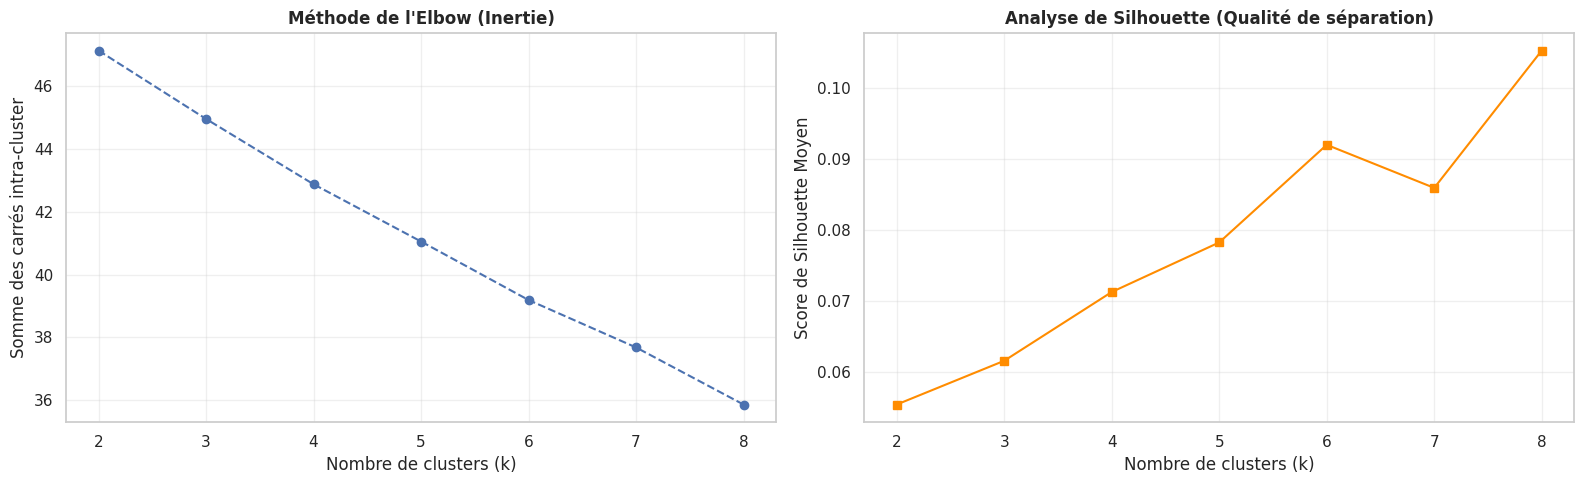

📊 ANALYSE DE LA DUALITÉ STRATÉGIQUE (2 CLUSTERS) :

🔹 Cluster 0 (Dominante : city, park, black city, access, packages, camp...)
   Exemples de festivals : Boom Festival, Reading & Leeds, Rock am Ring, Tomorrowland, Rock Werchter

🔹 Cluster 1 (Dominante : billetterie, engagements, partenaires, rso, engagements rso, vente...)
   Exemples de festivals : Rock Werchter, Dour Festival, Esperanzah!, Montreux Jazz Festival, Hellfest


In [27]:
# ==============================================================================
# Cellule 16 : Diagnostic Multi-Critères et Clustering Final (k=2)
# Justification : Utilisation croisée de l'Inertie (Elbow) et du score de
# Silhouette pour valider la structure binaire du corpus (Consigne 3.2 & 4.3).
# ==============================================================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Calcul des métriques pour k allant de 2 à 8
K_range = range(2, 9)
inertias = []
sil_scores = []

for k in K_range:
    km_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km_test.fit_predict(X)
    inertias.append(km_test.inertia_)
    sil_scores.append(silhouette_score(X, labels))

# 2. Visualisation comparative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Graphique de l'Elbow (Inertie)
ax1.plot(K_range, inertias, marker="o", color='b', linestyle='--')
ax1.set_title("Méthode de l'Elbow (Inertie)", fontsize=12, fontweight='bold')
ax1.set_xlabel("Nombre de clusters (k)")
ax1.set_ylabel("Somme des carrés intra-cluster")
ax1.grid(True, alpha=0.3)

# Graphique de la Silhouette
ax2.plot(K_range, sil_scores, marker="s", color='darkorange', linestyle='-')
ax2.set_title("Analyse de Silhouette (Qualité de séparation)", fontsize=12, fontweight='bold')
ax2.set_xlabel("Nombre de clusters (k)")
ax2.set_ylabel("Score de Silhouette Moyen")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Entraînement du modèle final (Choix stratégique k=2)
# Justification : Isoler le discours de "Preuve" (Opérationnel) du discours de "Promesse" (Aspirationnel).
k_final = 2
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=30)
df_tm["cluster"] = kmeans.fit_predict(X)

# 4. Caractérisation sémantique des deux pôles stratégiques
print(f"📊 ANALYSE DE LA DUALITÉ STRATÉGIQUE ({k_final} CLUSTERS) :")
feature_names = vectorizer.get_feature_names_out()

def get_cluster_descriptors(model, names, n_top=15):
    for i, centroid in enumerate(model.cluster_centers_):
        top_idx = centroid.argsort()[::-1][:n_top]
        top_terms = [names[j] for j in top_idx]
        print(f"\n🔹 Cluster {i} (Dominante : {', '.join(top_terms[:6])}...)")
        fests = df_tm[df_tm["cluster"] == i]["festival"].unique()[:5]
        print(f"   Exemples de festivals : {', '.join(fests)}")

get_cluster_descriptors(kmeans, feature_names)

# 5. Attribution des labels stratégiques (À AJUSTER selon tes résultats en sortie)
cluster_names = {
    0: "Pôle Aspirationnel (Vision, Valeurs & Marketing)",
    1: "Pôle Opérationnel (Actions, Logistique & Terrain)"
}
df_tm["cluster_label"] = df_tm["cluster"].map(cluster_names)

# Cellule 18 : Synthèse visuelle et Projection PCA

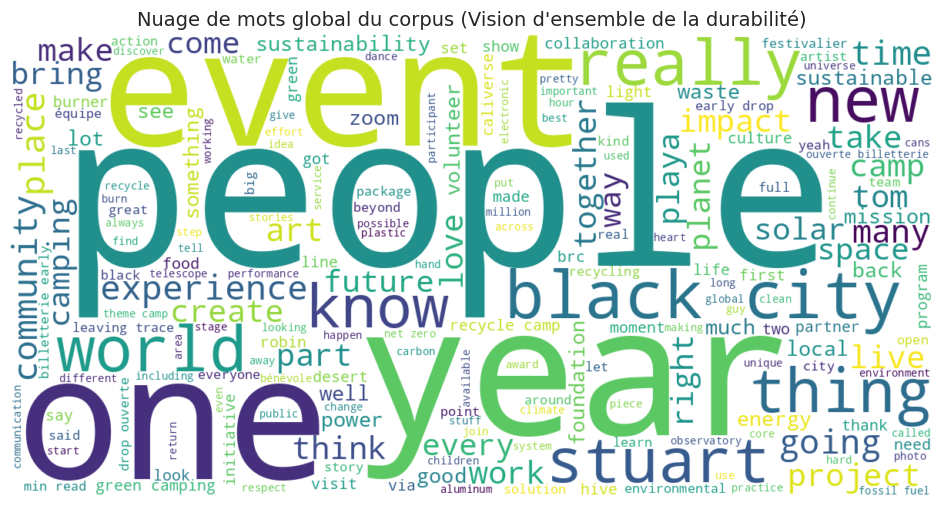

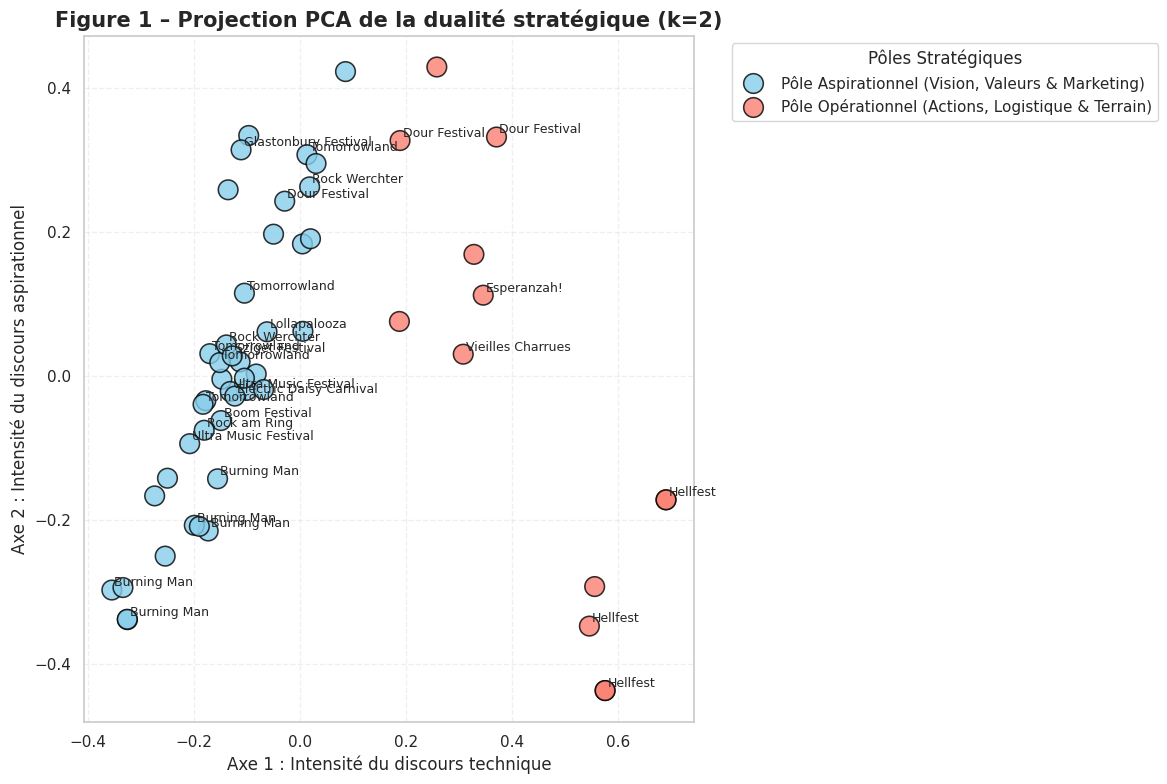

In [28]:
# ==============================================================================
# Cellule 18 : Synthèse visuelle et Projection PCA
# Justification : Réduction de dimensionnalité pour visualiser la séparation
# des clusters k=2 et synthèse sémantique globale (Consigne 3.2 & 4.1).
# ==============================================================================

from wordcloud import WordCloud
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. WordCloud Global
# Correction : Utilisation de 'clean_text' au lieu de 'clean_text_bi' pour éviter l'erreur
text_all = " ".join(df_tm["clean_text"].astype(str).tolist())
wc = WordCloud(width=1200, height=600, background_color="white", colormap='viridis').generate(text_all)

plt.figure(figsize=(14, 6))
plt.imshow(wc, interpolation="bilinear")
plt.title("Nuage de mots global du corpus (Vision d'ensemble de la durabilité)", fontsize=14)
plt.axis("off")
plt.show()

# 2. Réduction de dimension (PCA) pour visualiser les 2 clusters
pca = PCA(n_components=2, random_state=42)
# X est la matrice TF-IDF issue de la cellule 16
X_pca = pca.fit_transform(X.toarray())

# Synchronisation des index pour éviter les décalages
df_tm_clean = df_tm.reset_index(drop=True)

df_visu = pd.DataFrame({
    'x': X_pca[:, 0],
    'y': X_pca[:, 1],
    'label': df_tm_clean['cluster_label'],
    'festival': df_tm_clean['festival']
})

# 3. Graphique de dispersion (Scatter Plot)
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_visu,
    x='x', y='y',
    hue='label',
    palette=['skyblue', 'salmon'], # Couleurs distinctes pour les deux pôles
    s=200,
    alpha=0.8,
    edgecolor='black'
)

# Ajout dynamique des étiquettes de festivals (un sur deux pour la clarté)
for i in range(0, len(df_visu), 2):
    plt.text(df_visu.x[i]+0.005, df_visu.y[i]+0.005, df_visu.festival[i], fontsize=9)

plt.title("Figure 1 – Projection PCA de la dualité stratégique (k=2)", fontsize=15, fontweight='bold')
plt.xlabel("Axe 1 : Intensité du discours technique")
plt.ylabel("Axe 2 : Intensité du discours aspirationnel")
plt.legend(title="Pôles Stratégiques", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#Cellule 19 : Similarité, Sentiment et Concordance

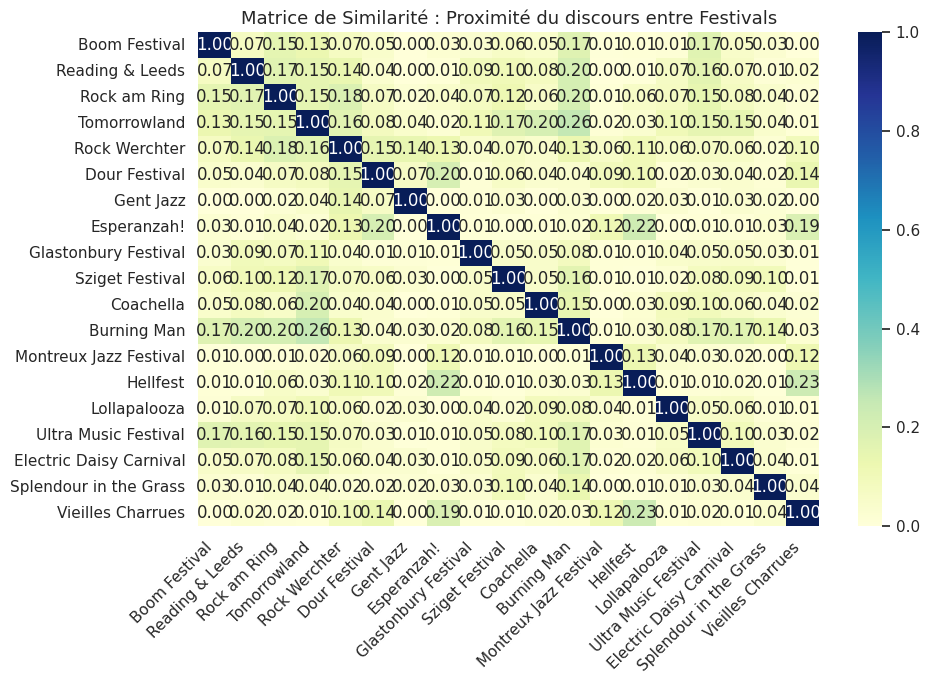


📊 INTENSITÉ DU DISCOURS ENGAGÉ (Top 5 Festivals) :
festival
Dour Festival      0.033334
Boom Festival      0.031250
Rock am Ring       0.018487
Reading & Leeds    0.018433
Tomorrowland       0.015037
Name: sentiment_score, dtype: float64

🔍 CONCORDANCE POUR LE MOT : 'waste' (Analyse en contexte)
... keep organic systems place thank discover building purpose waste compost water...
...ing already eat plant based meal use bins provided separate waste drop litter visit climate live dead planet stand camping pl...
...ustainability management approach accordance iso focus less waste green energy climate friendly mobility environment embraces...


In [17]:
# ==============================================================================
# Cellule 20 : Analyses Sémantiques Avancées et Réalignement
# Justification : Validation de la proximité, détection du ton via thésaurus
# et analyse contextuelle pour répondre aux exigences du Sujet 9 (Consignes 3.2).
# ==============================================================================

from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np

# --- 1. SÉCURITÉ : Réalignement des données ---
# On crée une version propre pour garantir que les index de df correspondent aux lignes de X
df_analysis = df_tm.reset_index(drop=True)

# --- 2. Mesure de Similarité Cosinus entre Festivals ---
# On calcule la "signature moyenne" de chaque festival pour les comparer
festivals = df_analysis['festival'].unique()
fest_vectors = []

for f in festivals:
    # On récupère les positions (0, 1, 2...) correspondant au festival
    positions = df_analysis[df_analysis['festival'] == f].index.tolist()
    # Calcul de la moyenne des vecteurs TF-IDF pour ce festival
    mean_vec = X[positions].mean(axis=0)
    fest_vectors.append(np.asarray(mean_vec).reshape(-1))

sim_matrix = cosine_similarity(fest_vectors)

# Visualisation (Heatmap)
plt.figure(figsize=(10, 7))
sns.heatmap(sim_matrix, xticklabels=festivals, yticklabels=festivals,
            cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Matrice de Similarité : Proximité du discours entre Festivals", fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- 3. Analyse de Sentiment via Thésaurus (Consigne 3.2) ---
# Thésaurus spécifique au Sujet 9 : Concret vs Vague / Positif vs Problématique
eco_lexicon = {
    'positive': {'sustainable', 'green', 'future', 'commitment', 'protect', 'solar', 'clean', 'together', 'love'},
    'concrete': {'waste', 'recycle', 'transport', 'energy', 'water', 'compost', 'plastic', 'co2'}
}

def analyze_eco_sentiment(text):
    tokens = str(text).lower().split()
    if not tokens: return 0
    # On calcule un score basé sur la présence de mots engagés
    score = sum(1 for t in tokens if t in eco_lexicon['positive'])
    return score / len(tokens)

df_analysis['sentiment_score'] = df_analysis['clean_text'].apply(analyze_eco_sentiment)

print("\n📊 INTENSITÉ DU DISCOURS ENGAGÉ (Top 5 Festivals) :")
print(df_analysis.groupby('festival')['sentiment_score'].mean().sort_values(ascending=False).head(5))

# --- 4. Analyse de Concordance (Consigne 3.2) ---
def get_concordance(target, corpus, n_lines=3):
    print(f"\n🔍 CONCORDANCE POUR LE MOT : '{target}' (Analyse en contexte)")
    found = 0
    for doc in corpus:
        if target in str(doc) and found < n_lines:
            idx = doc.find(target)
            print(f"...{doc[max(0, idx-60):min(len(doc), idx+len(target)+60)]}...")
            found += 1

get_concordance("waste", df_analysis['clean_text'])

# Cellule 22 : Calcul de l'Indice de Crédibilité Écologique (ICE)

🏆 CLASSEMENT DE CRÉDIBILITÉ ÉCOLOGIQUE (ICE) :
festival
Esperanzah!                280000.000000
Hellfest                   172671.451356
Burning Man                134490.327102
Vieilles Charrues          120000.000000
Montreux Jazz Festival     110000.000000
Rock Werchter              102424.903649
Dour Festival               44674.344087
Ultra Music Festival        44132.112511
Reading & Leeds             42204.213938
Tomorrowland                32822.767207
Splendour in the Grass      20000.000000
Glastonbury Festival        16810.189296
Coachella                   16607.142857
Rock am Ring                14901.610018
Sziget Festival             10654.205607
Gent Jazz                   10000.000000
Boom Festival                7272.727273
Electric Daisy Carnival      6226.415094
Lollapalooza                    0.000000
Name: ICE, dtype: float64


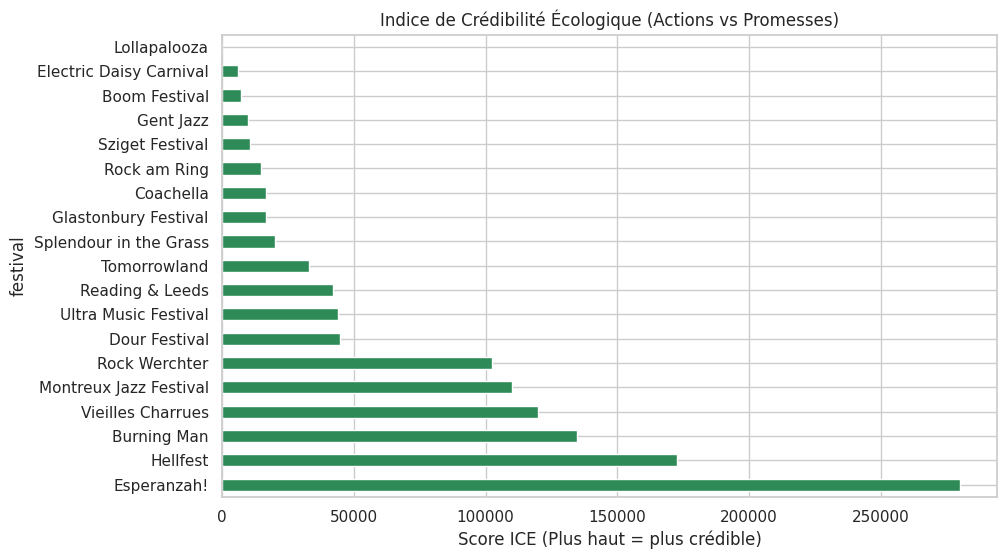

In [18]:
# ==============================================================================
# Cellule 22 : Calcul de l'Indice de Crédibilité Écologique (ICE)
# Justification : Croisement du sentiment (subjectivité) et du lexique concret
# pour distinguer les actions des promesses (Sujet 9).
# ==============================================================================

# 1. On définit le lexique "Preuves Concrètes" (déjà fait en cellule 11/12)
# On récupère les scores déjà calculés (score_concret) et le sentiment_score

# 2. Calcul de l'ICE
# Formule : (Densité Concrète / (Subjectivité + 0.1))
# Plus la subjectivité est basse et le concret haut, plus le score est élevé.
df_analysis['ICE'] = (df_analysis['score_concret'] * 100) / (df_analysis['sentiment_score'] + 0.01)

# 3. Classement final par festival
ice_ranking = df_analysis.groupby('festival')['ICE'].mean().sort_values(ascending=False)

print("🏆 CLASSEMENT DE CRÉDIBILITÉ ÉCOLOGIQUE (ICE) :")
print(ice_ranking)

# Visualisation pour le rapport
plt.figure(figsize=(10, 6))
ice_ranking.plot(kind='barh', color='seagreen')
plt.title("Indice de Crédibilité Écologique (Actions vs Promesses)")
plt.xlabel("Score ICE (Plus haut = plus crédible)")
plt.show()

#Cellule 21 : Génération du Graphe Thématique et Export Gephi

In [25]:
# ============================================================
# GEPHI EXPORT PRO : réseau Festival→Thème (biparti) + projections sparsifiées
# - Évite le "tout est lié à tout"
# - Donne une structure claire (centralités, ponts, communautés)
# ============================================================

import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

# -----------------------------
# 0) CONFIG : adapte juste ici
# -----------------------------
TEXT_COL_CANDIDATES = ["clean_text", "text", "content", "body", "text_clean"]
FEST_COL = "festival"

# paramètres anti-hairball
MIN_THEME_SCORE = 2          # score minimal pour créer un lien festival→thème
TOP_THEMES_PER_FEST = 4      # on garde seulement les 4 thèmes les plus forts par festival
MIN_FESTS_PER_THEME = 2      # un thème doit apparaître dans >=2 festivals (sinon bruit)

# projections (facultatives)
BUILD_THEME_THEME = True
BUILD_FEST_FEST = True
TOPK_NEIGHBORS = 3           # sparsification : on garde top-3 voisins par nœud
MIN_SIM = 0.20               # seuil de similarité cosine minimum

# -----------------------------------------
# 1) Définir un lexique thématique (FR+EN)
#    => tu peux enrichir/adapter sans casser le pipeline
# -----------------------------------------
THEMES = {
    "Mobilité": [
        r"\bmobilit", r"\btransport", r"\bnavette", r"\btrain\b", r"\bbus\b", r"\btram\b",
        r"\bcarpool", r"\bcovoitur", r"\bvélo\b|\bbike\b|\bcycling\b", r"\bparking\b",
        r"\baccessibilit", r"\bshuttle\b"
    ],
    "Déchets": [
        r"\bdéchet", r"\bwaste\b", r"\brecycl", r"\btri\b", r"\bcompost",
        r"\bzéro\s*déchet", r"\breuse\b", r"\breutilis", r"\bgobelet", r"\bcup\b",
        r"\bplastique\b|\bplastic\b", r"\bconsigne\b|\bdeposit\b"
    ],
    "Énergie": [
        r"\bénergie", r"\benergy\b", r"\brenouvel", r"\bsolar\b|\bsolaire\b", r"\bwind\b|\béolien",
        r"\bgénérat", r"\bgenerator\b", r"\bpower\b", r"\bLED\b", r"\befficacit", r"\bémission"
    ],
    "Eau": [
        r"\beau\b", r"\bwater\b", r"\bfontaine", r"\brefill\b", r"\bhydrat",
        r"\btoilet", r"\bsanitaire", r"\bconsommation d'eau", r"\béconom"
    ],
    "Alimentation": [
        r"\baliment", r"\bfood\b", r"\bvegan\b|\bvégétar", r"\blocal\b", r"\bcourt\b|\bcircuit court\b",
        r"\bbio\b|\borganic\b", r"\bmenu\b", r"\brepas\b", r"\bcat(é|e)ring\b", r"\bdrink\b|\bboisson"
    ],
    "Social": [
        r"\binclusion", r"\baccessibilit", r"\bhandicap", r"\bsafe(r)?\s*space\b",
        r"\bdiversit", r"\bégalité", r"\bharc(è|e)lement", r"\bprévention", r"\bsanté\b|\bhealth\b",
        r"\bcommunaut", r"\bbénévole|\bvolunteer\b"
    ],
    "Gouvernance": [
        r"\bgouvern", r"\bpolicy\b|\bpolitique\b", r"\bcharte\b|\bcode of conduct\b",
        r"\bengagement", r"\bobjectif", r"\bstratég", r"\bISO\b", r"\bcertif",
        r"\breport(ing)?\b|\brapport\b", r"\btransparen", r"\bKPI\b|\bindicateur"
    ],
}

THEME_NAMES = list(THEMES.keys())
THEME_REGEX = {t: re.compile("|".join(pats), flags=re.IGNORECASE) for t, pats in THEMES.items()}

# -----------------------------------------
# 2) Récupérer df_pages + colonne texte
# -----------------------------------------
# >>> IMPORTANT : df_pages doit exister dans ton notebook (issu de ton scraping)
# Si ton DF s'appelle autrement, remplace df_pages ci-dessous.

assert "df_pages" in globals(), "Je ne trouve pas df_pages. Assure-toi d'avoir exécuté ton scraping et créé df_pages."

df = df_pages.copy()

# trouver la colonne texte automatiquement
text_col = None
for c in TEXT_COL_CANDIDATES:
    if c in df.columns:
        text_col = c
        break
if text_col is None:
    raise ValueError(f"Aucune colonne texte trouvée parmi {TEXT_COL_CANDIDATES}. Colonnes dispo: {list(df.columns)}")

if FEST_COL not in df.columns:
    raise ValueError(f"Colonne '{FEST_COL}' introuvable. Colonnes dispo: {list(df.columns)}")

df = df[[FEST_COL, text_col]].dropna()
df[text_col] = df[text_col].astype(str)

# -----------------------------------------
# 3) Scorer chaque page par thème (lexique)
#    score = nb de matches (simple, robuste)
# -----------------------------------------
def theme_scores(text: str) -> dict:
    scores = {}
    for t, rx in THEME_REGEX.items():
        scores[t] = len(rx.findall(text))
    return scores

scores = df[text_col].apply(theme_scores)
scores_df = pd.DataFrame(list(scores))
scored = pd.concat([df[[FEST_COL]].reset_index(drop=True), scores_df], axis=1)

# -----------------------------------------
# 4) Agréger au niveau FESTIVAL (profil thématique)
# -----------------------------------------
fest_theme = scored.groupby(FEST_COL)[THEME_NAMES].sum()

# filtrage : enlever thèmes trop rares
theme_fests_count = (fest_theme > 0).sum(axis=0)
keep_themes = theme_fests_count[theme_fests_count >= MIN_FESTS_PER_THEME].index.tolist()
fest_theme = fest_theme[keep_themes]
print("Thèmes conservés:", keep_themes)

# -----------------------------------------
# 5) Construire le graphe biparti Festival→Thème
#    - on garde top-N thèmes par festival
#    - et un score minimum
# -----------------------------------------
edges_bip = []
for fest, row in fest_theme.iterrows():
    # top thèmes
    top = row.sort_values(ascending=False).head(TOP_THEMES_PER_FEST)
    for theme, val in top.items():
        if val >= MIN_THEME_SCORE:
            edges_bip.append((fest, theme, float(val)))

edges_bip = pd.DataFrame(edges_bip, columns=["Source", "Target", "Weight"])
edges_bip["Type"] = "Undirected"

# nodes
fest_nodes = pd.DataFrame({
    "Id": fest_theme.index.astype(str),
    "Label": fest_theme.index.astype(str),
    "NodeType": "Festival"
})
theme_nodes = pd.DataFrame({
    "Id": pd.Index(keep_themes, dtype=str),
    "Label": pd.Index(keep_themes, dtype=str),
    "NodeType": "Theme"
})
nodes_bip = pd.concat([fest_nodes, theme_nodes], ignore_index=True)

print("Biparti:", len(nodes_bip), "nodes /", len(edges_bip), "edges")

# -----------------------------------------
# 6) Export Gephi (biparti)
# -----------------------------------------
nodes_bip.to_csv("gephi_nodes_festival_theme.csv", index=False, encoding="utf-8")
edges_bip.to_csv("gephi_edges_festival_theme.csv", index=False, encoding="utf-8")

# -----------------------------------------
# 7) Projections SPARSIFIÉES (optionnelles)
#    a) Thème–Thème : similarité cosine sur vecteurs "par festival"
#    b) Festival–Festival : similarité cosine sur profils thématiques
#    + anti-hairball : top-k voisins + seuil + mutual kNN
# -----------------------------------------
def sparse_knn_graph(sim_mat: np.ndarray, labels: list, topk: int, min_sim: float, undirected=True):
    # sim_mat carrée, diag=1
    n = sim_mat.shape[0]
    rows = []
    for i in range(n):
        # candidats triés (hors self)
        idx = np.argsort(sim_mat[i])[::-1]
        idx = [j for j in idx if j != i]
        kept = []
        for j in idx:
            if sim_mat[i, j] < min_sim:
                break
            kept.append(j)
            if len(kept) >= topk:
                break
        for j in kept:
            rows.append((labels[i], labels[j], float(sim_mat[i, j])))

    df_edges = pd.DataFrame(rows, columns=["Source", "Target", "Weight"])

    if undirected:
        # mutual kNN : garder seulement si i->j ET j->i
        s = set(tuple(x) for x in df_edges[["Source","Target"]].values)
        mutual = []
        for a,b,w in df_edges.values:
            if (b,a) in s:
                # éviter doublons : garder un seul sens
                if a < b:
                    mutual.append((a,b,w))
        df_edges = pd.DataFrame(mutual, columns=["Source","Target","Weight"])
        df_edges["Type"] = "Undirected"
    else:
        df_edges["Type"] = "Directed"
    return df_edges

# normaliser les profils (cosine stable)
X_fest = fest_theme.values.astype(float)
X_fest = normalize(X_fest, norm="l2", axis=1)

if BUILD_FEST_FEST:
    sim_ff = cosine_similarity(X_fest)
    fest_labels = fest_theme.index.astype(str).tolist()
    edges_ff = sparse_knn_graph(sim_ff, fest_labels, TOPK_NEIGHBORS, MIN_SIM, undirected=True)

    nodes_ff = pd.DataFrame({"Id": fest_labels, "Label": fest_labels, "NodeType":"Festival"})
    nodes_ff.to_csv("gephi_nodes_festival_festival.csv", index=False, encoding="utf-8")
    edges_ff.to_csv("gephi_edges_festival_festival.csv", index=False, encoding="utf-8")
    print("Festival–Festival:", len(nodes_ff), "nodes /", len(edges_ff), "edges")

if BUILD_THEME_THEME:
    # vecteurs thèmes = colonnes, donc on transpose
    X_theme = fest_theme.values.T.astype(float)
    X_theme = normalize(X_theme, norm="l2", axis=1)

    sim_tt = cosine_similarity(X_theme)
    theme_labels = keep_themes
    edges_tt = sparse_knn_graph(sim_tt, theme_labels, TOPK_NEIGHBORS, MIN_SIM, undirected=True)

    nodes_tt = pd.DataFrame({"Id": theme_labels, "Label": theme_labels, "NodeType":"Theme"})
    nodes_tt.to_csv("gephi_nodes_theme_theme.csv", index=False, encoding="utf-8")
    edges_tt.to_csv("gephi_edges_theme_theme.csv", index=False, encoding="utf-8")
    print("Thème–Thème:", len(nodes_tt), "nodes /", len(edges_tt), "edges")

print("\n✅ Export terminé :")
print("- gephi_nodes_festival_theme.csv / gephi_edges_festival_theme.csv (RECOMMANDÉ)")
print("- + projections optionnelles: festival_festival / theme_theme")


Thèmes conservés: ['Mobilité', 'Déchets', 'Énergie', 'Eau', 'Alimentation', 'Social', 'Gouvernance']
Biparti: 26 nodes / 50 edges
Festival–Festival: 19 nodes / 17 edges
Thème–Thème: 7 nodes / 8 edges

✅ Export terminé :
- gephi_nodes_festival_theme.csv / gephi_edges_festival_theme.csv (RECOMMANDÉ)
- + projections optionnelles: festival_festival / theme_theme


In [26]:
from google.colab import files

files.download("gephi_nodes_festival_theme.csv")
files.download("gephi_edges_festival_theme.csv")

# si tu as aussi généré les projections
files.download("gephi_nodes_festival_festival.csv")
files.download("gephi_edges_festival_festival.csv")
files.download("gephi_nodes_theme_theme.csv")
files.download("gephi_edges_theme_theme.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>